# Get started

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/101-get_started.ipynb)

This notebook contains the simple examples of time series forecasting pipeline
using ETNA library.

**Table of contents**

* [Loading dataset](#chapter1)
* [Plotting](#chapter2)
* [Forecasting single time series](#chapter3)
    * [Naive forecast](#section_3_1)
    * [Prophet](#section_3_2)
    * [Catboost](#section_3_3)
* [Forecasting multiple time series](#chapter4)

In [1]:
!pip install "etna[prophet]" -q
!pip uninstall prophet -y -q
!pip install "prophet>=1.1.5" -q

In [2]:
import warnings

import pandas as pd

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [3]:
!wget https://raw.githubusercontent.com/tinkoff-ai/etna/refs/heads/master/examples/data/monthly-australian-wine-sales.csv

--2025-11-01 10:44:29--  https://raw.githubusercontent.com/tinkoff-ai/etna/refs/heads/master/examples/data/monthly-australian-wine-sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181 (3.1K) [text/plain]
Saving to: ‘monthly-australian-wine-sales.csv’

monthly-australian- 100%[===================>]   3.11K  --.-KB/s    in 0s      

2025-11-01 10:44:29 (48.1 MB/s) - ‘monthly-australian-wine-sales.csv’ saved [3181/3181]



In [4]:
df = pd.read_csv("/content/monthly-australian-wine-sales.csv")
df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


Library works with a special data structure called `TSDataset`. It stores all the necessary information to work with multiple time series.

To create an instance of `TSDataset` we should reformat our `df` into one of two supported formats:

- Long format
  - Has columns `timestamp`, `segment`, `target`
  - Column `timestamp` stores timestamp values
  - Column `target` stores values of time series
  - Column `segment` stores identifiers of different time series
- Wide format
  - Index stores timestamp values
  - Columns has two levels with names 'segment', 'feature'. Each column stores values for a given feature in a given segment.

More details about the formats could be found in documentation for `etna.datasets.DataFrameFormat`.

Usually it is much easier to create dataframe in a long format. So, let's do it!

In [5]:
df["timestamp"] = pd.to_datetime(df["month"])
df["target"] = df["sales"]
df.drop(columns=["month", "sales"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


To get a wide format from a long format the `TSDataset.to_dataset` could be used:

In [6]:
from etna.datasets.tsdataset import TSDataset
wide_df = TSDataset.to_dataset(df)
wide_df.head()

/usr/local/lib/python3.12/dist-packages/etna/settings.py:35: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.12/dist-packages/etna/settings.py:64: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
/usr/local/lib/python3.12/dist-packages/etna/settings.py:89: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.12/dist-packages/etna/settings.py:98: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install et

segment,main
feature,target
timestamp,
1980-01-01,15136.0
1980-02-01,16733.0
1980-03-01,20016.0
1980-04-01,17708.0
1980-05-01,18019.0


Time to create a `TSDataset`! Additionally to passing a dataframe we should specify the frequency of our data. \
Our library implements 2 ways to do this:
1. Using [`pd.DataOffsets` objects](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects)
2. Using [offset aliases](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases)

In our case, it is monthly data at the beginning of the month. Let's look at both options:

In [7]:
#  принудительное указание частоты на случай пропусков в данных
# 1. Use pd.offsets
from pandas.tseries.offsets import MonthBegin
ts = TSDataset(df, freq=MonthBegin(1))
# Both methods give the same result, but be careful,
# sometimes aliases are different for different versions pandas.
# We recommend using the pd.DateOffsets.

# 2. Use offset alias
ts = TSDataset(df, freq="1MS")
ts

# Alias Description
# B   - business day frequency                            BQE - business quarter end frequency
# C   - custom business day frequency                     QS  - quarter start frequency
# D   - calendar day frequency                            BQS - business quarter start frequency
# W   - weekly frequency                                  YE  - year end frequency
# ME  - month end frequency                               BYE - business year end frequency
# SME - semi-month end frequency (15th and end of month)  YS  - year start frequency
# BME - business month end frequency                      BYS - business year start frequency
# CBME - custom business month end frequency              h   - hourly frequency
# MS  - month start frequency                             bh  - business hour frequency
# SMS - semi-month start frequency (1st and 15th)         cbh - custom business hour frequency
# BMS - business month start frequency                    min - minutely frequency
# CBMS - custom business month start frequency            s   - secondly frequency
# QE  - quarter end frequency                             ms  - milliseconds
#                                                         us  - microseconds
#                                                         ns  - nanoseconds

# Deprecated since version 2.2.0:
# Aliases H, BH, CBH, T, S, L, U, and N are deprecated
# in favour of the aliases h, bh, cbh, min, s, ms, us, and ns.

segment,main
feature,target
timestamp,
1980-01-01,15136.0
1980-02-01,16733.0
1980-03-01,20016.0
1980-04-01,17708.0
1980-05-01,18019.0
...,...
1994-04-01,26323.0
1994-05-01,23779.0


Both methods give the same result, but be careful, sometimes aliases are different for different versions `pandas`. We recommend using the `pd.DateOffsets`.

If you accidentally set the wrong data frequency, you will get a warning, for example:

In [8]:
wrong_freq_ts = TSDataset(df, freq="D")

/usr/local/lib/python3.12/dist-packages/etna/datasets/tsdataset.py:377: UserWarning: You probably set wrong freq. Discovered freq in you data is MS, you set D
  warnings.warn(


Okay, now we can look at the basic information about the dataset

In [9]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
end_timestamp: 1994-08-01 00:00:00
         start_timestamp  length  num_missing
segments                                     
main          1980-01-01     176            0


Or in `DataFrame` format

In [10]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


Library also has several internal public datasets. You can use them to compare some models with public benchmarks. It is easy to use:

In [11]:
from etna.datasets import load_dataset
ts = load_dataset(name="australian_wine_sales_monthly")
ts.head()

segment,main
feature,target
timestamp,
1980-01-01,15136.0
1980-02-01,16733.0
1980-03-01,20016.0
1980-04-01,17708.0
1980-05-01,18019.0


You can get the full list of available internal datasets:

In [12]:
from etna.datasets.internal_datasets import list_datasets
list_datasets()

['ETTh1',
 'ETTh2',
 'ETTm1',
 'ETTm2',
 'IHEPC_T',
 'australian_wine_sales_monthly',
 'electricity_15T',
 'm3_monthly',
 'm3_other',
 'm3_quarterly',
 'm3_yearly',
 'm4_daily',
 'm4_hourly',
 'm4_monthly',
 'm4_quarterly',
 'm4_weekly',
 'm4_yearly',
 'tourism_monthly',
 'tourism_quarterly',
 'tourism_yearly',
 'traffic_2008_10T',
 'traffic_2008_hourly',
 'traffic_2015_hourly',
 'weather_10T']

More information about internal datasets can be found in this [documentation page](https://docs.etna.ai/stable/internal_datasets.html).

## 2. Plotting <a class="anchor" id="chapter2"></a>

Let's take a look at the time series in the dataset

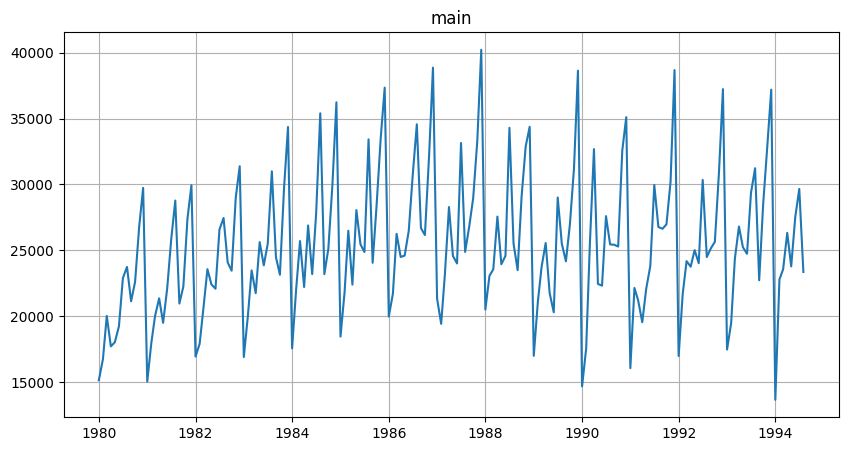

In [13]:
ts.plot()

## 3. Forecasting single time series <a class="anchor" id="chapter3"></a>

Our library contains a wide range of different models for time series forecasting. Let's look at some of them.

In [14]:
warnings.filterwarnings("ignore")

Let's predict the monthly values in 1994 for our dataset.

In [15]:
HORIZON = 8

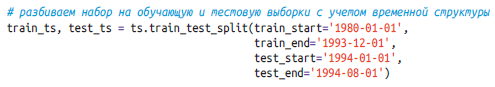

In [16]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
# print(train_ts.info(), test_ts.info())

train_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1993-12-01,168,0,1,0,0,0,MS


In [17]:
test_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1994-01-01,1994-08-01,8,0,1,0,0,0,MS


### 3.1 Naive forecast <a class="anchor" id="section_3_1"></a>

We will start by using the `NaiveModel` that just takes the value from `lag` time steps before.

This model doesn't require any features, so to make a forecast we should define pipeline with this model and set a proper horizon value.

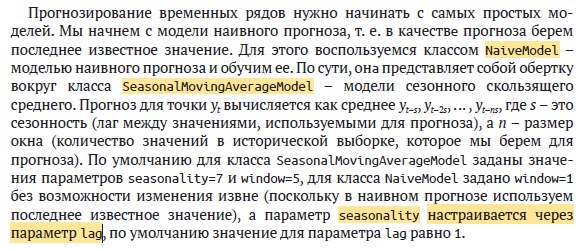

In [18]:
# We will start by using the NaiveModel
# that just takes the value from lag time steps before.
# This model doesn't require any features,
# so to make a forecast we should define pipeline with this model
# and set a proper horizon value.
from etna.models import NaiveModel
from etna.pipeline import Pipeline

# Define a model
# параметр seasonality настраивается через параметр lag,
# по умолчанию значение для параметра lag равно 1.
# 12 - это число месяцев в году (сезонность)
model = NaiveModel(lag=12)

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

Let's make a forecast.

In [19]:
# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
# Calling pipeline.forecast without parameters
# makes a forecast for the next HORIZON points
# after the end of the training set.
forecast_ts = pipeline.forecast()

Calling `pipeline.forecast` without parameters makes a forecast for the next `HORIZON` points after the end of the training set.

In [20]:
forecast_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1994-01-01,1994-08-01,8,0,1,0,0,0,MS


In [21]:
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,17466.0
1994-02-01,19463.0
1994-03-01,24352.0
1994-04-01,26805.0
1994-05-01,25236.0
1994-06-01,24735.0
1994-07-01,29356.0
1994-08-01,31234.0


In [22]:
test_ts

segment,main
feature,target
timestamp,
1994-01-01,13652.0
1994-02-01,22784.0
1994-03-01,23565.0
1994-04-01,26323.0
1994-05-01,23779.0
1994-06-01,27549.0
1994-07-01,29660.0
1994-08-01,23356.0


Now let's look at the result metric and plot the prediction. All the methods already built-in in ETNA.

In [23]:
# Now let's look at the result metric and plot the prediction.
# All the methods already built-in in ETNA.
from etna.metrics import SMAPE #MAE, SMAPE, MSE, MAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

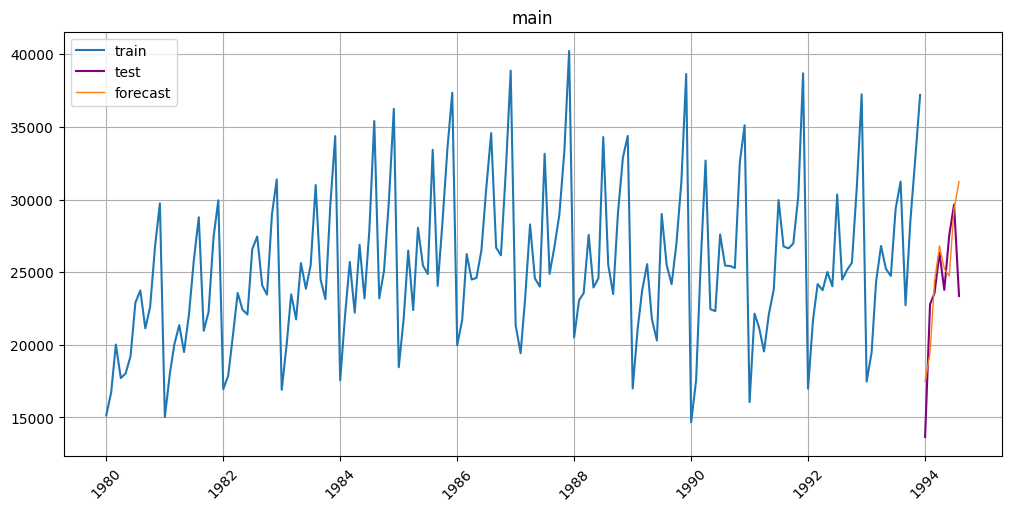

In [24]:
from etna.analysis import plot_forecast

plot_forecast(
    forecast_ts=forecast_ts,
    test_ts=test_ts,
    train_ts=train_ts,
    n_train_samples=168
)

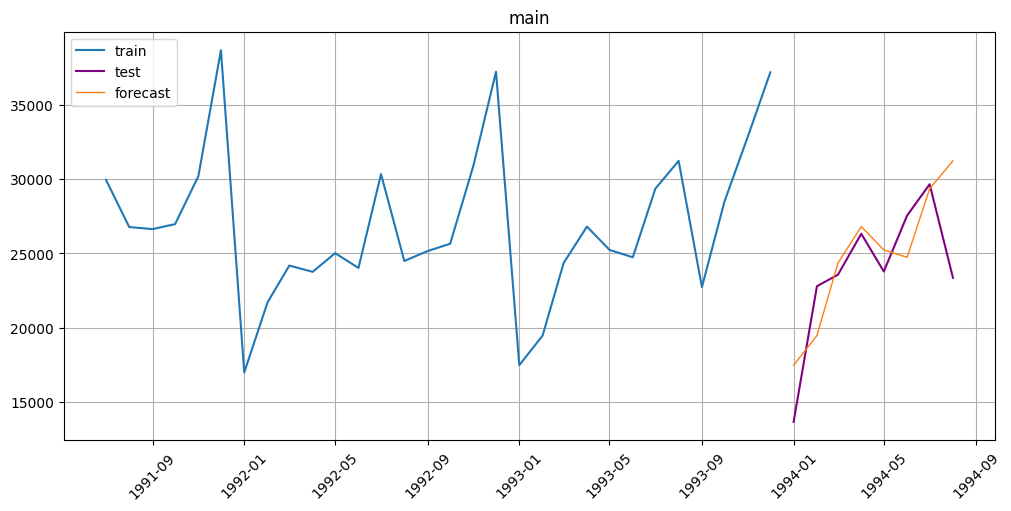

In [25]:
plot_forecast(
    forecast_ts=forecast_ts,
    test_ts=test_ts,
    train_ts=train_ts,
    n_train_samples=30
)

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

Now we can try to improve the forecast by using Prophet model.

In [34]:
# Удаляем всё, что связано с prophet
!pip uninstall prophet -y -q

# Устанавливаем последнюю стабильную версию, совместимую с Python 3.12
!pip install "prophet>=1.1.5" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 69.8 MB/s eta 0:00:00


In [35]:
!pip install "etna[prophet]" -q

In [37]:
from etna.models import ProphetModel

# Define a model
model = ProphetModel()

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.629157584538676}

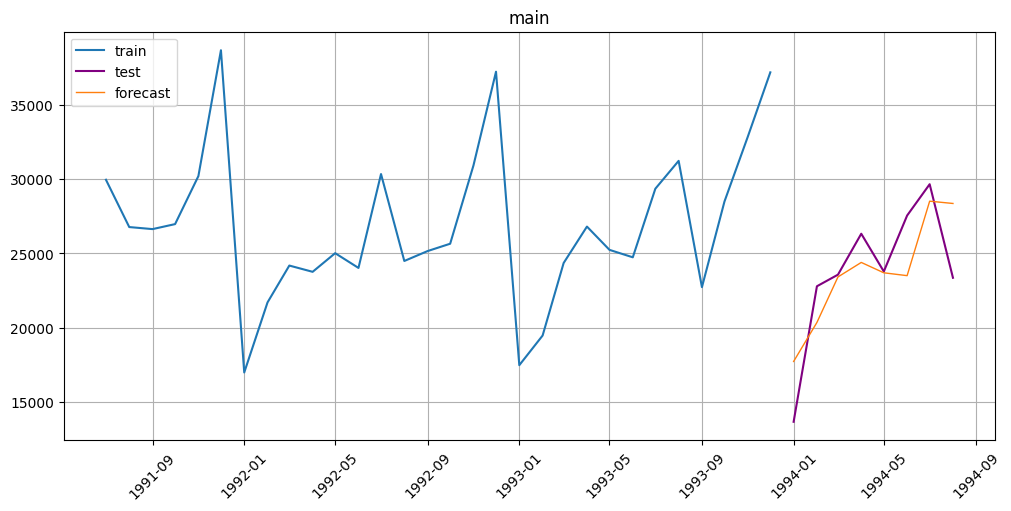

In [41]:
plot_forecast(
    forecast_ts=forecast_ts,
    test_ts=test_ts,
    train_ts=train_ts,
    n_train_samples=30
)

In [43]:
import prophet
prophet.__version__

'1.1.7'

### 3.3 Catboost <a class="anchor" id="section_3_3"></a>

Finally, let's try the ML-model. This kind of models require some features to make a forecast.

#### 3.3.1 Basic transforms

ETNA has a wide variety of transforms to work with data, let's take a look at some of them.

**Lags**

Lag transformation is the most basic one. It gives us some previous value of the time series. For example, the first lag is the previous value, and the fifth lag is the value five steps ago. Lags are essential for regression models, like linear regression or boosting, because they allow these models to grasp information about the past.

The scheme of working:

![lags-scheme](https://github.com/MinyaevAndrey/etna/blob/master/examples/assets/get_started/lags.gif?raw=1)

In [42]:
from etna.transforms import LagTransform
# you should use lags >= HORIZON when using a Pipeline.
lags = LagTransform(
    in_column="target",
    lags=list(range(HORIZON, 24)),
    out_column="lag"
)

There are some limitations on available lags during the forecasting. Imagine that we want to make a forecast for 3 step ahead. We can't take the previous value when we make a forecast for the last step, we just don't know the value. For this reason, you should use `lags` >= `HORIZON` when using a `Pipeline`.

**Statistics**

Statistics are another essential feature. It is also useful for regression models as it allows them to look at the information about the past but in different ways than lags. There are different types of statistics: mean, median, standard deviation, minimum and maximum on the interval.

The scheme of working:

![statistics-scheme](https://github.com/MinyaevAndrey/etna/blob/master/examples/assets/get_started/statistics.gif?raw=1)

As we can see, the window includes the current timestamp. For this reason, we shouldn't apply the statistics transformations to target variable, we should apply it to lagged target variable.

In [44]:
from etna.transforms import MeanTransform
mean = MeanTransform(
    in_column=f"lag_{HORIZON}",
    window=12
)

**Dates**

The time series also has the timestamp column that we have not used yet. But date number in a week and in a month, as well as week number in year or weekend flag can be really useful for the machine learning model. And ETNA allows us to extract all this information with `DateFlagTransform`.

In [45]:
from etna.transforms import DateFlagsTransform
date_flags = DateFlagsTransform(
    day_number_in_week=False,
    day_number_in_month=False,
    week_number_in_month=False,
    month_number_in_year=True,
    season_number=True,
    is_weekend=False,
    out_column="date_flag",
)

**Logarithm**

However, there is another type of transform that alters the column itself. We call it “inplace transform”. The easiest is `LogTransform`. It logarithms values in a column.

In [46]:
from etna.transforms import LogTransform
log = LogTransform(
    in_column="target",
    inplace=True
)

#### 3.3.2 Forecasting

Now let's pass these transforms into our `Pipeline`. It will do all the work with applying the transforms and making exponential inverse transformation after the prediction.

In [47]:
from etna.models import CatBoostMultiSegmentModel
# Define a pipeline
pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[lags, mean, date_flags, log],
    horizon=HORIZON
)
# Fit the pipeline
pipeline.fit(train_ts)
# Make a forecast
forecast_ts = pipeline.forecast()

In [48]:
train_ts

segment,main
feature,target
timestamp,
1980-01-01,15136.0
1980-02-01,16733.0
1980-03-01,20016.0
1980-04-01,17708.0
1980-05-01,18019.0
...,...
1993-08-01,31234.0
1993-09-01,22724.0


In [49]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.45087182576396}

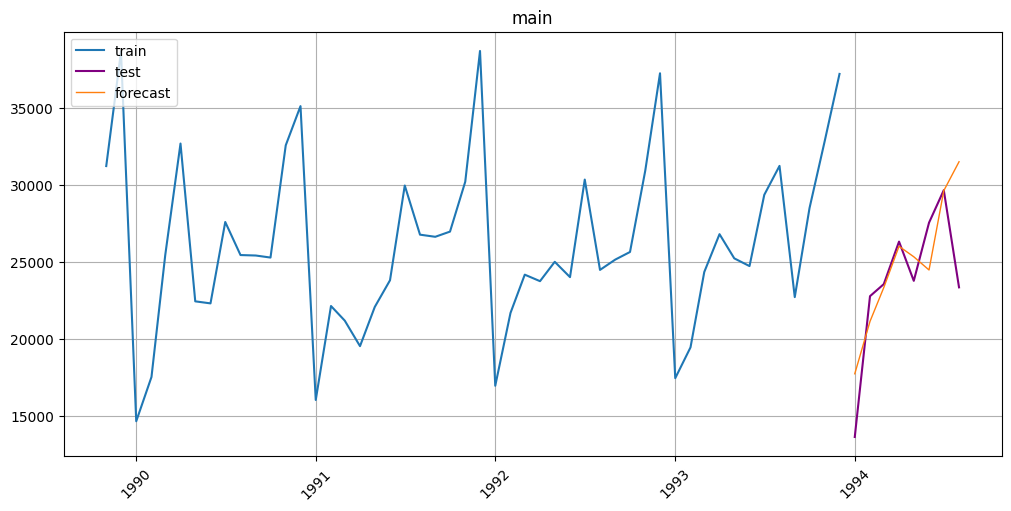

In [50]:
plot_forecast(
    forecast_ts=forecast_ts,
    test_ts=test_ts,
    train_ts=train_ts,
    n_train_samples=50
)

## 4. Forecasting multiple time series <a class="anchor" id="chapter4"></a>

In this section you may see example of how easily ETNA works with multiple time series and get acquainted with other transforms the library contains.

In [51]:
HORIZON = 30

In [52]:
!wget https://raw.githubusercontent.com/tinkoff-ai/etna/refs/heads/master/examples/data/example_dataset.csv

--2025-11-01 11:08:34--  https://raw.githubusercontent.com/tinkoff-ai/etna/refs/heads/master/examples/data/example_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33422 (33K) [text/plain]
Saving to: ‘example_dataset.csv’

example_dataset.csv 100%[===================>]  32.64K  --.-KB/s    in 0.01s   

2025-11-01 11:08:35 (2.70 MB/s) - ‘example_dataset.csv’ saved [33422/33422]



In [53]:
df = pd.read_csv("/content/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


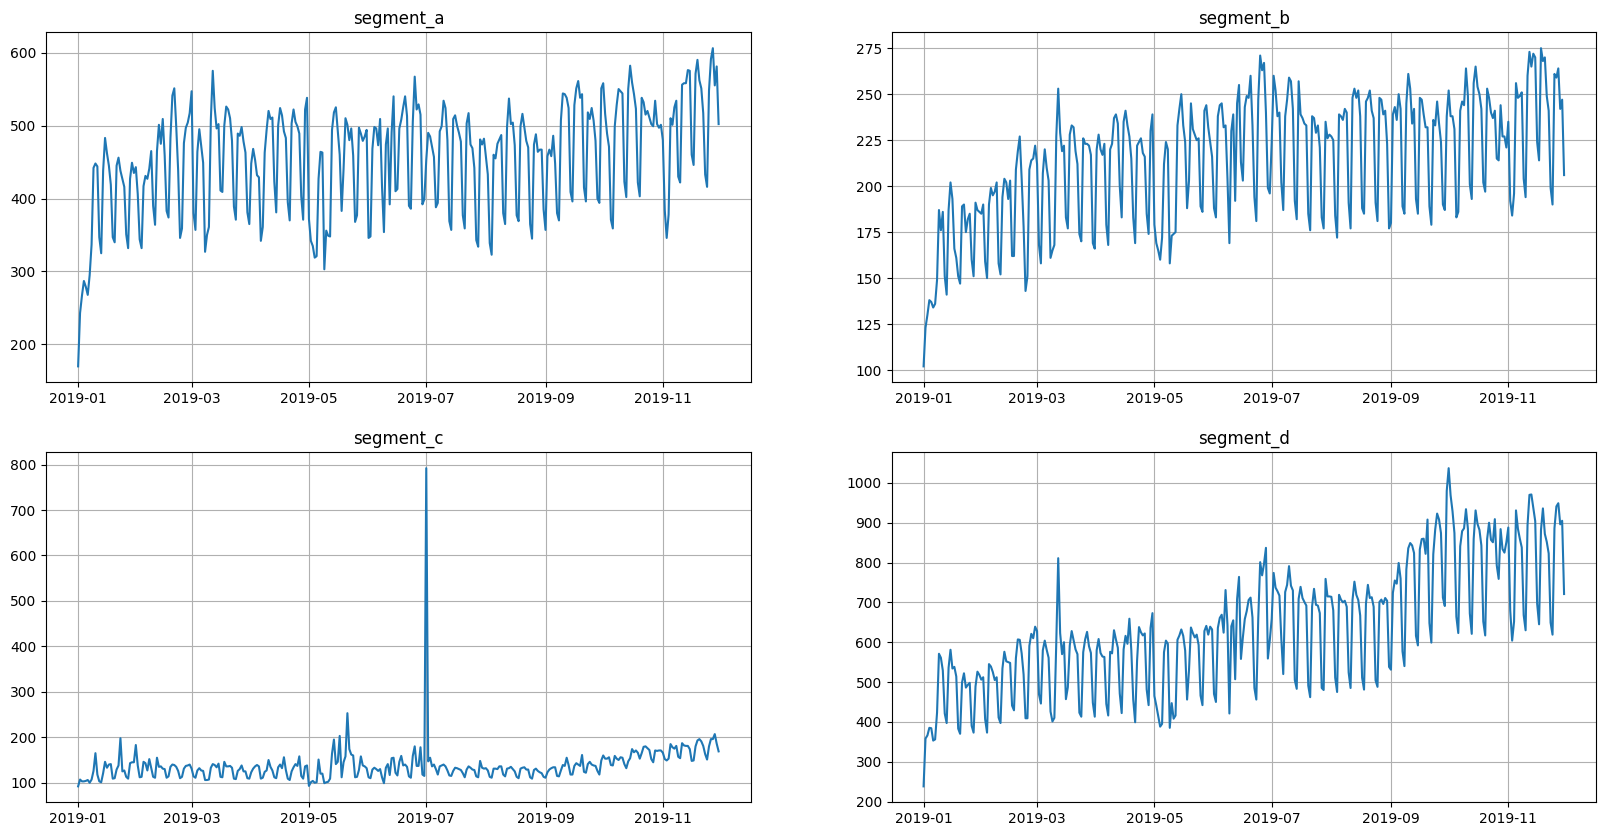

In [54]:
ts = TSDataset(df, freq="D")
ts.plot()

In [55]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
end_timestamp: 2019-11-30 00:00:00
          start_timestamp  length  num_missing
segments                                      
segment_a      2019-01-01     334            0
segment_b      2019-01-01     334            0
segment_c      2019-01-01     334            0
segment_d      2019-01-01     334            0


In [56]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [57]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
end_timestamp: 2019-11-30 00:00:00
          start_timestamp  length  num_missing
segments                                      
segment_a      2019-11-01      30            0
segment_b      2019-11-01      30            0
segment_c      2019-11-01      30            0
segment_d      2019-11-01      30            0


In [58]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(
    in_column="target",
    lags=list(range(HORIZON, 96)),
    out_column="lag"
)
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
# Define a pipeline
pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[log, trend, lags, date_flags, seg, mean],
    horizon=HORIZON
)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [59]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 6.27623264819618,
 'segment_b': 6.1907557763309065,
 'segment_c': 11.917140632244468,
 'segment_d': 5.406749419867033}

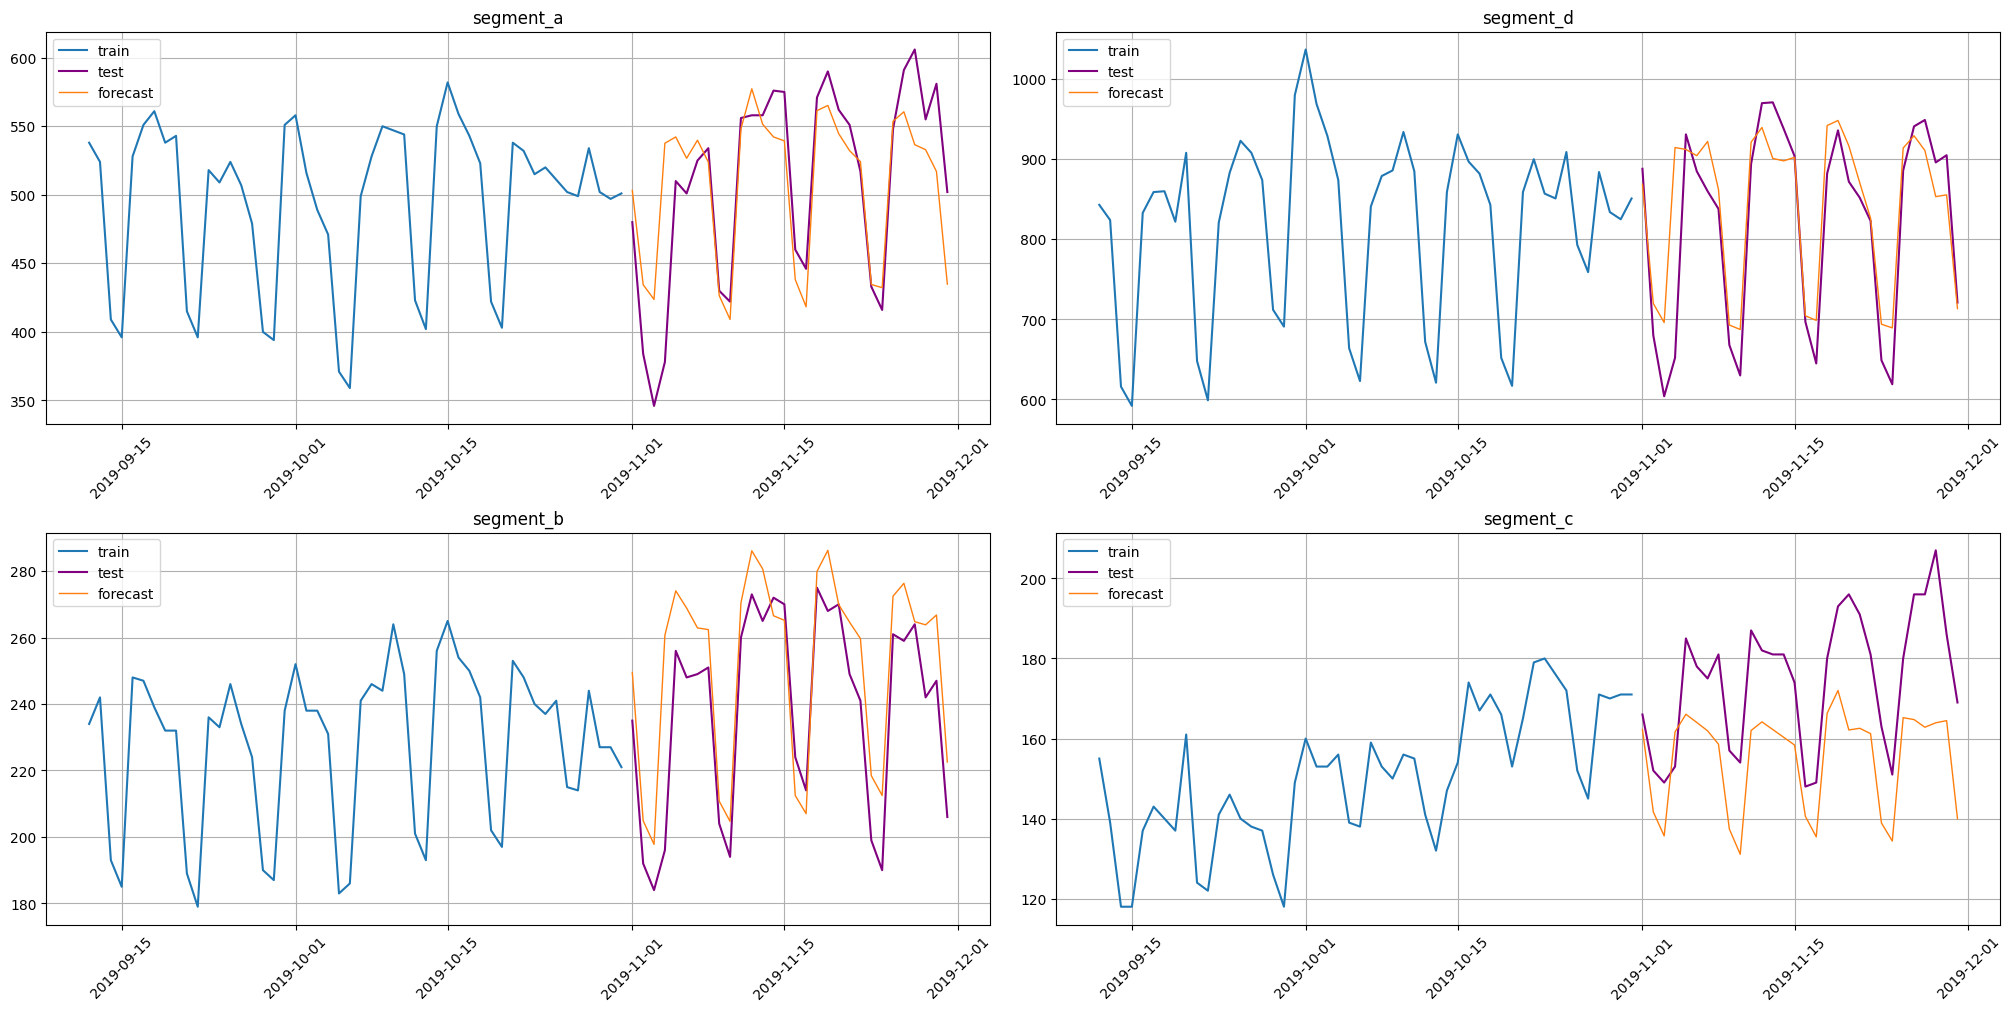

In [60]:
plot_forecast(
    forecast_ts=forecast_ts,
    test_ts=test_ts,
    train_ts=train_ts,
    n_train_samples=50
)